# Exploring gym environment
[useful ref](https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/)
>     Passenger locations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    - 4: in taxi (Taxi is yellow)
    Destinations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    Actions:
    There are 6 discrete deterministic actions:
    - 0: move south
    - 1: move north
    - 2: move east
    - 3: move west
    - 4: pickup passenger
    - 5: drop off passenger

> Summary
    5x5x5x4 = 500 possible states

` Each step in environment returns
    Observation
    Reward
    done: If step resulted in drop off / pick up -> episode
    Info`

> Blue letter : Current passenger pick up locations
  Purple letter is current destination

In [2]:
import gym

In [3]:
env = gym.make('Taxi-v3')
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## States and Actions

In [4]:
print("Actions {}".format(env.action_space))
print("States {}".format(env.observation_space))

Actions Discrete(6)
States Discrete(500)


## Rendering different states
### Random steps


In [5]:
# reset to get random initial state
env.reset()
result = env.step(1) # step env by 1 timestep, returns: <observation, reward, done, info>
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)


### Trying out a move
> set random positions
 

In [6]:
env.s = env.action_space.sample()
print(env.s)
env.render()


5
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)


Move south and visualize state

In [7]:
# set position for taxi row, col, passenger, destination
# Location of passenger: Yellow, destination is Green, Taxi in row 0, col 1
newState = env.step(0)
env.s = newState
print(env.s)
env.render()

(388, -1, False, {'prob': 1.0})
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)


Take random action and visualize

In [8]:
from IPython.display import clear_output
from time import sleep
import random
env.reset()
ticks = 0
done = False
while not done:    
    k = random.randint(0,3)
    newState = env.step(k)
    print(newState)
    env.render()    
    sleep(.2)
    clear_output(wait=True)
    ticks += 1
    if ticks == 100:
        done = True

(213, -1, False, {'prob': 1.0})
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)


Reward table for the final state from above

In [9]:

print(newState[0])
env.P[newState[0]]

213


{0: [(1.0, 313, -1, False)],
 1: [(1.0, 113, -1, False)],
 2: [(1.0, 233, -1, False)],
 3: [(1.0, 213, -1, False)],
 4: [(1.0, 213, -10, False)],
 5: [(1.0, 213, -10, False)]}

`{action: [(probability, nextstate, reward, done)]}`

# Module 2

## Q learning algorithm

$$
Q(S_{t}, A_{t})  = Q(S_{t}, A_{t})+\alpha[R_{t+1}+\gamma*max Q(S_{t+1}, a) - Q(S_{t}, A_{t})]
$$

 alpha: Step size / learning rate (0<=1)
 
  gamma: Discount factor (0<=1)

  R_t+1: Observed reward
  
  Q(S_t, A_t): Current Q value

## Implementing algorithm

In [10]:
# Q table
import numpy as np
import time 

# defined q table as states * actions
q_table = np.zeros([env.observation_space.n, env.action_space.n])


In [11]:
# define hyperparameters
alpha = 0.1
gamma = 0.7
epsilon = 0.1

epochs, penalties, reward = 0,0,0

In [12]:
steps = 50000
acc_reward = []
episode_times = []
start_time = time.time()
for i in range(1, steps):
    # reset the environment
    state = env.reset()
    done = False
    episode_reward = 0
    while not done:
        clear_output(wait=True)
        # explore vs exploit prob        
        exp = random.uniform(0,1)
        if exp < epsilon:
            # pick from sample in action space
            action =env.action_space.sample()
        else:
            # exploit best value
            action = np.argmax(q_table[state])

        next_state, reward, done, info = env.step(action)
        episode_reward += reward
        #print("Action:" + action)
        #print(next_state)

        # get values for q function
        currentQ = q_table[state, action]

        #max q next state
        maxNxt = np.max(q_table[next_state])

        newQ = (1- alpha) * currentQ + alpha*(reward + gamma * maxNxt)
        # save new q value for the given state and action
        q_table[state, action] = newQ

        # move to the next state
        state = next_state

        # check the reward
        if reward == -10:
            penalties += 1

        epochs += 1

    if i % 100 == 0:
        print(f"Finished episode {i}")
    
    acc_reward.append(episode_reward)
    episode_times.append(time.time())




Finished episode 49800


### Test episode
Use of trainined agent from given a state

In [13]:
testState = env.reset()
print(testState)
env.render()


181
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [14]:
%%time
frames = []
state = testState
epochs = 0
done = False
while not done:
    clear_output(wait=True)
    # exploit best value
    action = np.argmax(q_table[state])       
    
    state, reward, done, info = env.step(action)
    
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )
    
    epochs += 1

print(f"Finished in {epochs}")

Finished in 17
Wall time: 21 ms


### Visualize the training episode

In [15]:
def display_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])

        sleep(.2)

display_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)



### Reward accumulated per episode vs time

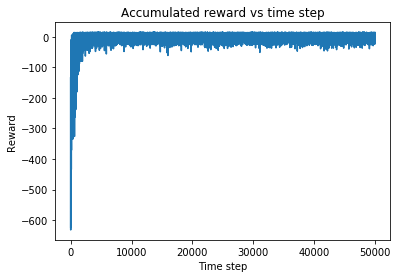

In [16]:
import matplotlib.pyplot as plt

plt.plot(acc_reward)
plt.title("Accumulated reward vs time step")
plt.xlabel("Time step")
plt.ylabel("Reward")
plt.show()